学習がうまくいったのかどうかを確かめる

1. 予測誤差（全ての時刻における二乗誤差の平均）がinnovationの分散より小さけれな良い

$\sqrt{\mathbb{E}[(\hat X_t-X_t)^2]}$  と  $\sigma^{\ast}$の大小

2. というより普通にinnovationを予測できていればいいのでは？

3. 一応正規性とか独立性も確認して、できていなかったとしてもどこができていないのかを見るべき。でないと正則化の係数を変えられない

In [1]:
%matplotlib inline
import argparse
import os
path = os.getcwd()
path=path[:path.find('timeseries-WGAN')+15]
import warnings
warnings.simplefilter('ignore')# 警告を非表示
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
import sys
sys.path.append(path+"/")
import random
import time
import statsmodels.api as sm
from scipy.stats import norm
import japanize_matplotlib
from scipy.stats import gaussian_kde
import plotly

import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

In [2]:
# 人工データを生成してくれる機械が置いてあるところ
import tsModel
# 学習用のニューラルネットが置いてあるところ
import models

まずはチェック用のデータを取得

$p^{\ast}=7$, $\phi^{\ast}=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]$, $\mu^{\ast}=0$, $\sigma^{\ast}=2$, $_{test}T=1000$<br>
に従うARモデルから生成されるデータ

In [3]:
phi_ast=[0.3,-0.4,0.2,-0.5,0.6,-0.1,0.1]
p_ast=len(phi_ast)
mu_ast=0
sigma_ast=2

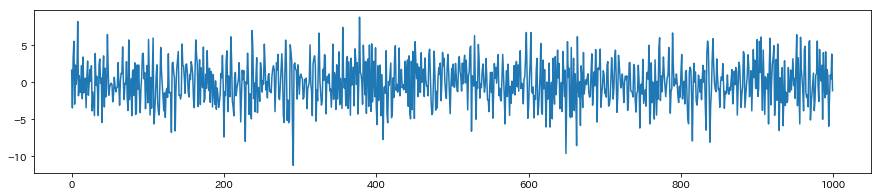

In [4]:
# まずはある時系列を作る（訓練データと生成モデルは同じ）
seed=2**32 - 1
testT=1000
testData = tsModel.SARIMA(a=phi_ast, N=testT, random_seed=seed, mu=mu_ast, sigma=sigma_ast)
plt.figure(figsize=(15,3))
plt.plot(testData, label="観測時系列")
testData=torch.tensor(testData, dtype=torch.float)

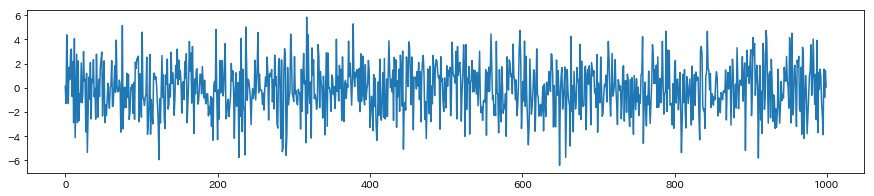

In [5]:
eps = tsModel.SARIMA(a=phi_ast, N=testT, random_seed=seed, mu=mu_ast, sigma=sigma_ast, return_innovation=True)
plt.figure(figsize=(15,3))
plt.plot(eps, label="観測時系列")

## $p=7$の場合

In [6]:
hat_p=7

## まずは予測誤差がそれなりに小さくなっているかどうかを確かめる。

まずは推定モデルを読み込む

In [11]:
! ls output-images/p7/

No0_3_preloss_epoch1000_batchSize64_DataSeed0.png
No0_floss_epoch10_batchSize64_GP1_Corr0_DataSeed0.png
No0_gloss_epoch10_batchSize64_GP1_Corr0_DataSeed0.png
No2_floss_epoch2000_batchSize64_DataSeed0.png
No2_gloss_epoch2000_batchSize64_DataSeed0.png


In [7]:
! ls parameters/p7/No1*

parameters/p7/No1_generator_epoch1000_batchSize64_DataSeed0.pth
parameters/p7/No1_generator_epoch100_batchSize64_DataSeed0.pth
parameters/p7/No1_generator_epoch200_batchSize64_DataSeed0.pth
parameters/p7/No1_generator_epoch300_batchSize64_DataSeed0.pth
parameters/p7/No1_generator_epoch400_batchSize64_DataSeed0.pth
parameters/p7/No1_generator_epoch500_batchSize64_DataSeed0.pth
parameters/p7/No1_generator_epoch600_batchSize64_DataSeed0.pth
parameters/p7/No1_generator_epoch700_batchSize64_DataSeed0.pth
parameters/p7/No1_generator_epoch800_batchSize64_DataSeed0.pth
parameters/p7/No1_generator_epoch900_batchSize64_DataSeed0.pth
parameters/p7/No1_generator_minLoss_batchSize64_DataSeed0.pth
parameters/p7/No1_predictor_epoch0_batchSize64_DataSeed0.pth
parameters/p7/No1_predictor_epoch1000_batchSize64_DataSeed0.pth
parameters/p7/No1_predictor_epoch100_batchSize64_DataSeed0.pth
parameters/p7/No1_predictor_epoch200_batchSize64_DataSeed0.pth
parameters/p7/No1_predictor_epoch300_batchSize64_DataSee

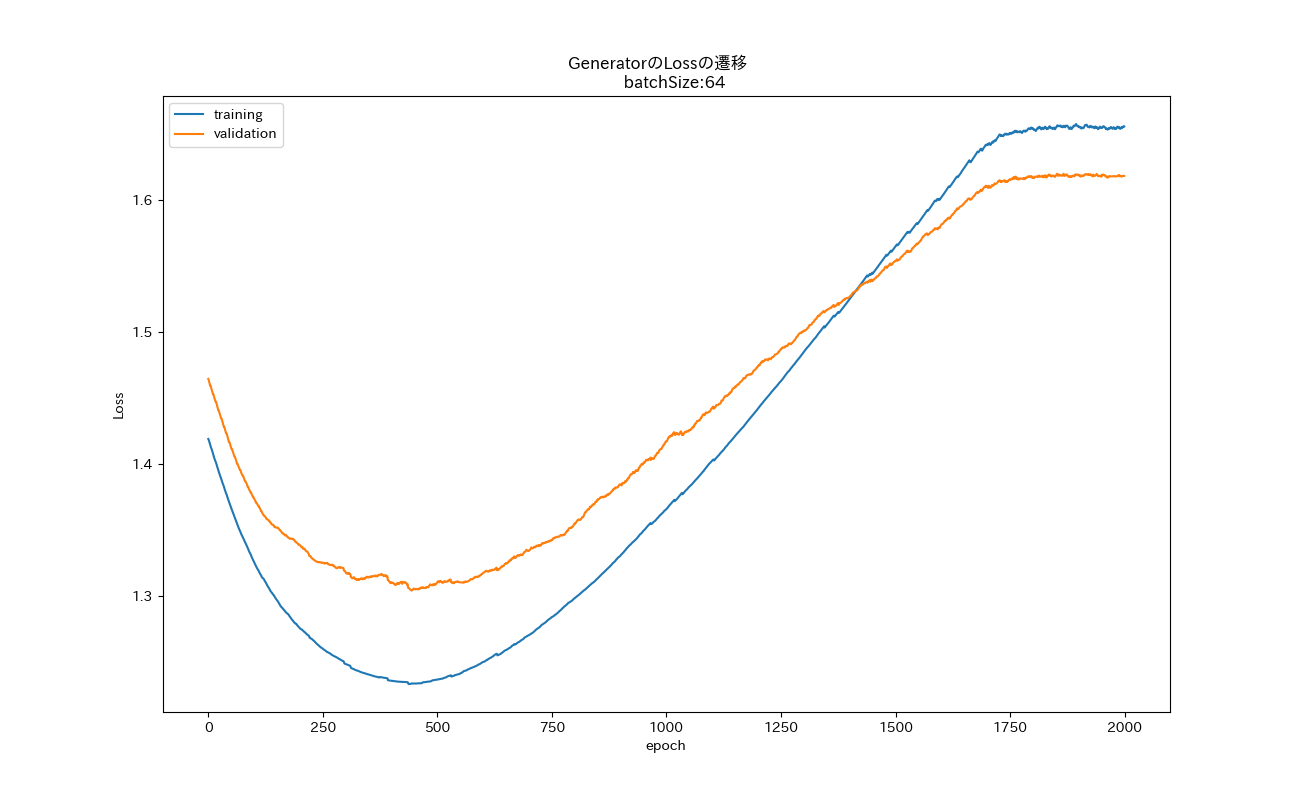

In [16]:
from IPython.display import Image
Image("./output-images/p7/No2_gloss_epoch2000_batchSize64_DataSeed0.png")

In [8]:
parameter_path = "parameters/p{0}/No1_predictor_epoch0_batchSize64_DataSeed0.pth".format(hat_p)
# parameter_path = "parameters/p{0}/predictor_epoch2000_batchSize64_GP1_Corr1_DataSeed0.pth".format(hat_p)
print(parameter_path)
predictor = models.LinearPredictNet(p=hat_p, input_dim=1, is_bias=True)
predictor.load_state_dict(torch.load(parameter_path))

parameters/p7/No1_predictor_epoch0_batchSize64_DataSeed0.pth


<All keys matched successfully>

#### まずはpretrainの結果を見る

In [9]:
hat_mu = float(predictor.state_dict()['fc1.bias'])
print(mu_ast)
print(hat_mu)
hat_sigma = float(predictor.state_dict()['fc1.weight'][0][0])
print(sigma_ast)
print(hat_sigma)
hat_phi = [round(float(predictor.state_dict()['fc1.weight'][0][hat_p-i]),3) for i in range(0, hat_p)]
print(phi_ast)
print(hat_phi)
print(sum([np.abs(phi_ast[i]-hat_phi[i]) for i in range(len(hat_phi))])/len(hat_phi)) # 真の値との絶対誤差の平均

0
0.07615945488214493
2
-0.0266505628824234
[0.3, -0.4, 0.2, -0.5, 0.6, -0.1, 0.1]
[0.268, -0.371, 0.215, -0.533, 0.566, -0.047, 0.113]
0.029857142857142867


#### 次にGeneratorとして、正規分布とのWasserstein距離最小化の学習まで行った後の場合

In [17]:
epoch=400

parameter_path = "parameters/p{0}/No1_generator_epoch{1}_batchSize64_DataSeed0.pth".format(hat_p, epoch)
generator = models.LinearGenerator(p = hat_p, input_dim=1, is_bias=False)
generator.load_state_dict(torch.load(parameter_path))

parameter_path = "parameters/p{0}/No1_predictor_epoch{1}_batchSize64_DataSeed0.pth".format(hat_p, epoch)
predictor = models.LinearPredictNet(p=hat_p, input_dim=1, is_bias=True)
predictor.load_state_dict(torch.load(parameter_path))

<All keys matched successfully>

$F_{\phi}$のパラメータは？

In [21]:
hat_mu = float(predictor.state_dict()['fc1.bias'])
print(mu_ast)
print(hat_mu)
hat_sigma = float(predictor.state_dict()['fc1.weight'][0][0])
print(sigma_ast)
print(hat_sigma)
hat_phi = [round(float(predictor.state_dict()['fc1.weight'][0][hat_p-i]),3) for i in range(0, hat_p)]
print(phi_ast)
print(hat_phi)
print(sum([np.abs(phi_ast[i]-hat_phi[i]) for i in range(len(hat_phi))])/len(hat_phi))# 真の値との絶対誤差の平均

0
0.07476191222667694
2
0.9915590882301331
[0.3, -0.4, 0.2, -0.5, 0.6, -0.1, 0.1]
[0.256, -0.373, 0.22, -0.512, 0.575, -0.066, 0.109]
0.024428571428571435


pretrainよりよくなったところもあれば悪くなったところもある。(全体としてはちょっとよくなってる？)

$G_{\theta}$のパラメータは？

In [22]:
generator.state_dict()

OrderedDict([('fc1.weight',
              tensor([[-0.0127,  0.0237, -0.2376, -0.0942, -0.0754,  0.0832, -0.0949,  0.4414]]))])

これだけ見ても分からんね

### テストデータにおける$\epsilon$を見てみるか

In [24]:
hat_eps = [generator(testData[i:i+8].view(1,1,8)).item() for i in range(100)]
true_eps = [eps[i+7] for i in range(100)]

# 可視化してみる
fig = plotly.graph_objs.Figure(
    data=[plotly.graph_objs.Scatter(x=np.linspace(start=1, stop=100, num=100), y=hat_eps, name="hat_eps", yaxis='y'),
          plotly.graph_objs.Scatter(x=np.linspace(start=1, stop=100, num=100), y=true_eps, name="true_eps", yaxis='y'),
                ], 
    layout=plotly.graph_objs.Layout(title="AR(7)モデル",
                legend={"x":1, "y":0.1},
                xaxis={"title":"time","range":[1,100]},
                yaxis={"title":"value"},
                width = 900,       # 全体のサイズ
                height = 450,
                )
)
plotly.offline.iplot(fig)

tripleのgeneratorと比較してみる

In [25]:
parameter_path = "../triple-experiment/parameters/p7/No6_generator_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth"
generator = models.LinearGenerator(p = hat_p, input_dim=1, is_bias=False)
generator.load_state_dict(torch.load(parameter_path))

<All keys matched successfully>

In [26]:
hat_eps = [generator(testData[i:i+8].view(1,1,8)).item() for i in range(100)]
true_eps = [eps[i+7] for i in range(100)]

# 可視化してみる
fig = plotly.graph_objs.Figure(
    data=[plotly.graph_objs.Scatter(x=np.linspace(start=1, stop=100, num=100), y=hat_eps, name="hat_eps", yaxis='y'),
          plotly.graph_objs.Scatter(x=np.linspace(start=1, stop=100, num=100), y=true_eps, name="true_eps", yaxis='y'),
                ], 
    layout=plotly.graph_objs.Layout(title="AR(7)モデル",
                legend={"x":1, "y":0.1},
                xaxis={"title":"time","range":[1,100]},
                yaxis={"title":"value"},
                width = 900,       # 全体のサイズ
                height = 450,
                )
)
plotly.offline.iplot(fig)

### GANの学習をflossの値が最小のところで止めた場合

In [16]:
epoch=2000
parameter_path = "parameters/p{0}/No6_generator_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth".format(hat_p, epoch)
generator = models.LinearGenerator(p = hat_p, input_dim=1, is_bias=False)
generator.load_state_dict(torch.load(parameter_path))
parameter_path = "parameters/p{0}/No6_discriminator_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth".format(hat_p, epoch)
discriminator = models.Discriminator(q=0, discriminator_hidden_unit=64)
discriminator.load_state_dict(torch.load(parameter_path))
parameter_path = "parameters/p{0}/No6_predictor_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth".format(hat_p, epoch)
print(parameter_path)
predictor = models.LinearPredictNet(p=hat_p, input_dim=1, is_bias=True)
predictor.load_state_dict(torch.load(parameter_path))

parameters/p7/No6_predictor_minLoss_batchSize64_GP1_Corr0_DataSeed0.pth


<All keys matched successfully>

In [17]:
hat_mu = float(predictor.state_dict()['fc1.bias'])
print(mu_ast)
print(hat_mu)
hat_sigma = float(predictor.state_dict()['fc1.weight'][0][0])
print(sigma_ast)
print(hat_sigma)
hat_phi = [round(float(predictor.state_dict()['fc1.weight'][0][hat_p-i]),3) for i in range(0, hat_p)]
print(phi_ast)
print(hat_phi)

0
-0.008678808808326721
2
1.0101759433746338
[0.3, -0.4, 0.2, -0.5, 0.6, -0.1, 0.1]
[0.391, -1.015, 0.614, -0.59, 0.679, -0.296, 0.672]


In [26]:
generator.state_dict()

OrderedDict([('fc1.weight',
              tensor([[0.1248, 0.1784, 0.0977, 0.3359, 0.2124, 0.2894, 0.0955, 0.3131]]))])